# Author: Ana Abel Tomas Taimo

# About Dataset
Link: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk?resource=download
## Context
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## Content
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
## Acknowledgements
Source: UCI

# import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

<ipython-input-2-0768ea3751d8>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


Import the dataset that I have downloaded with pandas library

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
dt=pd.read_csv("/content/drive/MyDrive/Project1/german_credit_data.csv")
dt.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [5]:

dt= dt.drop(['Unnamed: 0'], axis=1)

In [6]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


The Saving accounts and Checking account attributes, there are missing elements/values, so I will replace the missing values with the mode, as they are categorical values.

# Exploratory data analysis

## Dealing with the missing values

In [7]:
# Get the percentage of missing values for each attribute with missing values
raw_data_mv = dt.isnull().sum()/len(dt)*100 
raw_data_mv = raw_data_mv.drop(raw_data_mv[raw_data_mv == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :raw_data_mv})
missing_data

,Missing Ratio
Checking account,39.4
Saving accounts,18.3


Text(0.5, 1.0, 'Attributes wiht Missing Values')

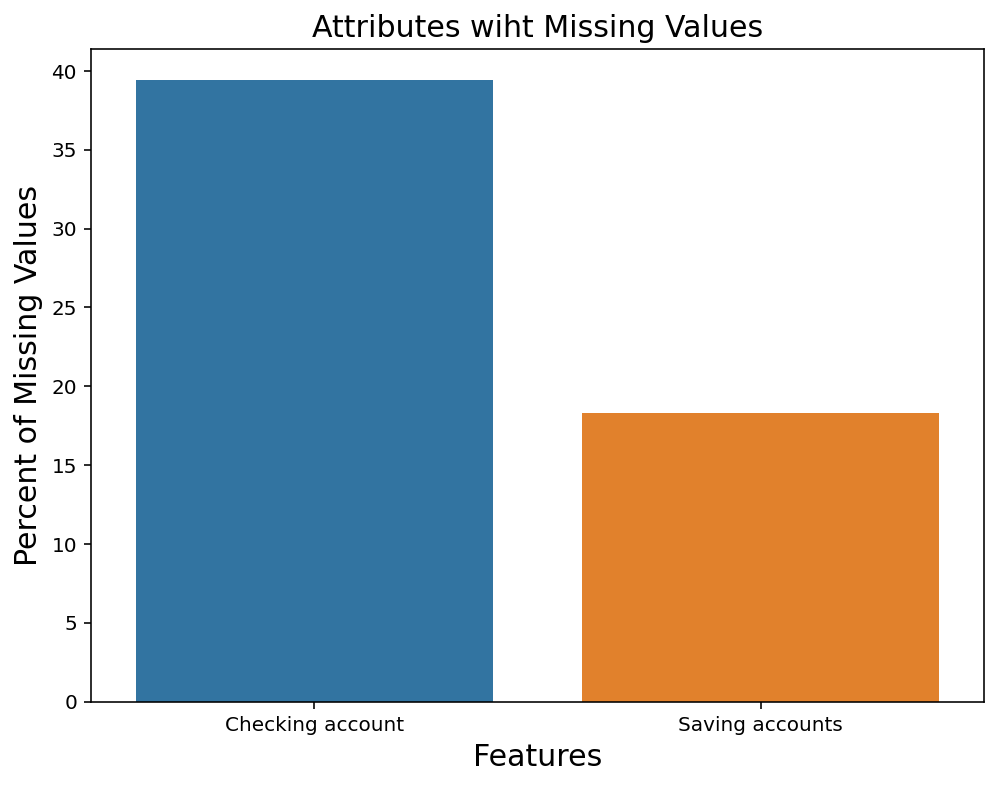

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=raw_data_mv.index, y=raw_data_mv)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Attributes wiht Missing Values', fontsize=15)

Above we can see that all attributes except the Checking account and Saving accounts attributes, are not missing any data. Since the amount of missing data does not exceed 60% I will replace them with the mode.  

In [9]:
# Replace missing values with mode
dt['Checking account'] = dt['Checking account'].fillna(dt['Checking account'].mode()[0])
dt['Saving accounts'] = dt['Saving accounts'].fillna(dt['Saving accounts'].mode()[0])
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [10]:
dt.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [11]:
dt.describe(include= ["O"])

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,1000,1000,1000,1000
unique,2,3,4,3,8,2
top,male,own,little,little,car,good
freq,690,713,786,668,337,700


For the target/meta attribute we have that the most frequent class is "good", with a frequency of 700

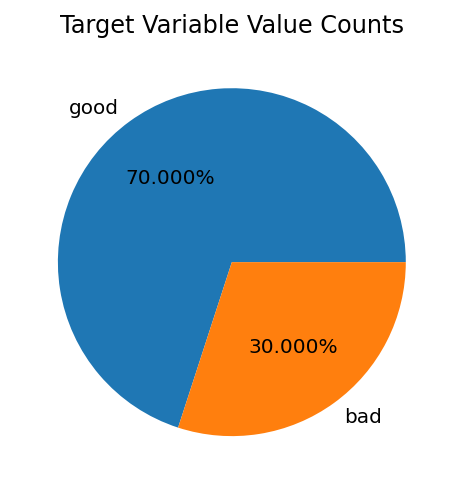

In [12]:
# get the set of distinct Risks
labels = dt.Risk.unique()

# get the count of each class
sizes = dt.Risk.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

The data is not balanced for the target attribute

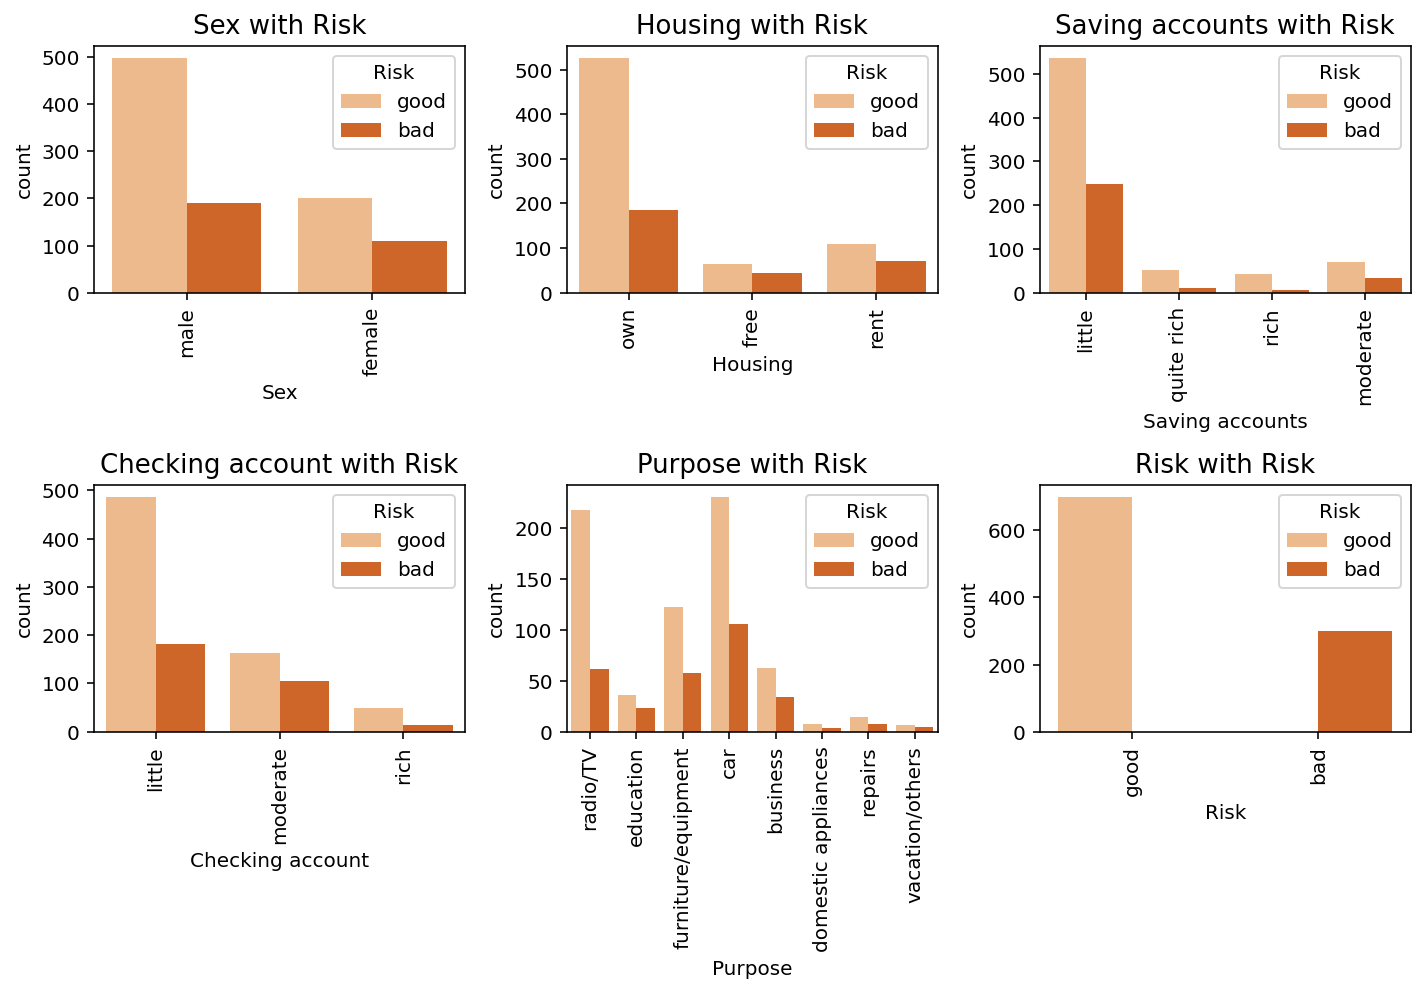

In [13]:
cat_cols = dt.dtypes[dt.dtypes == "object"].index
plt.figure(figsize=(10,7))
for index, col in enumerate(cat_cols):
    plt.subplot(2,3, index+1)
    sns.countplot(x=col, hue='Risk', data=dt, palette='Oranges')
    plt.title(f'{col} with Risk', fontsize=13)
    plt.xticks(rotation=90)
plt.tight_layout()


In this project to deal with the unbalanced data I will use the sklearn.utils.class_weight.compute_sample_weight tool, to estimate the coefficients of each attribute, taking into account that the date are not balanced 

# Skeweness

## Probabilities distributions fuctions

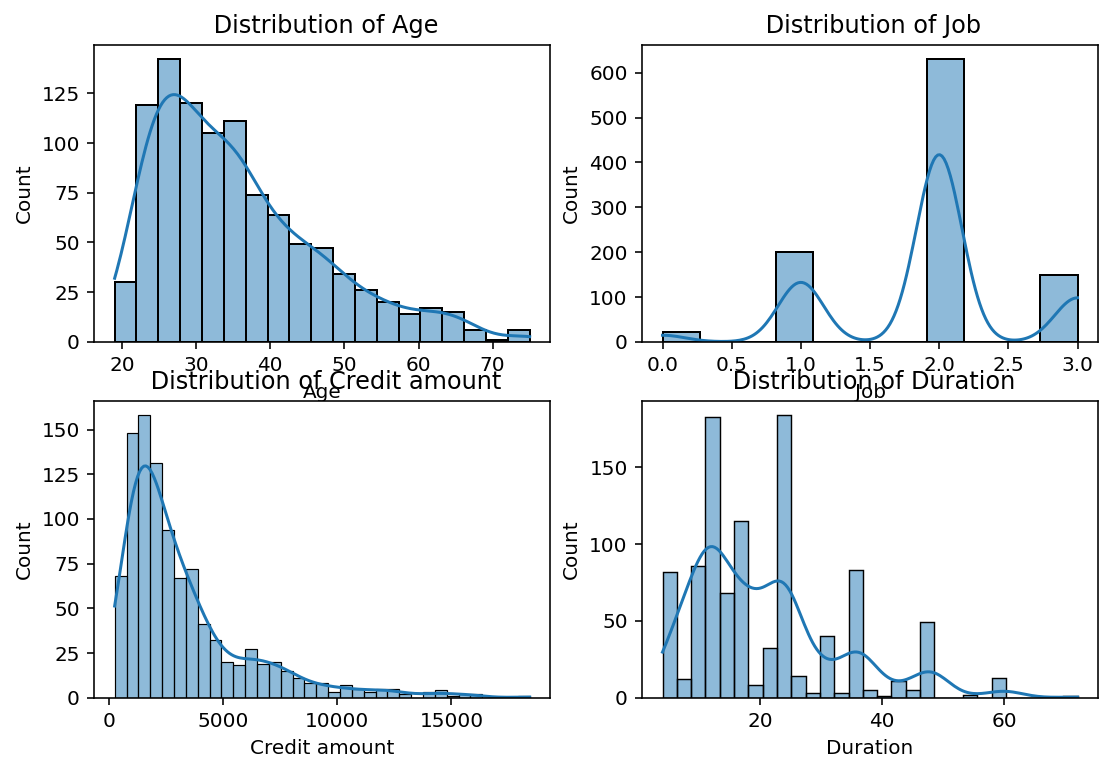

In [14]:
num_cols= dt.dtypes[dt.dtypes != "object"].index
plt.figure(figsize=(9,6))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.histplot(x=col, kde= True, data=dt)
    plt.title(f' Distribution of {col}')

In [15]:
# take the numerical features
numeric_feats = dt.dtypes[dt.dtypes != "object"].index

# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = dt[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
# select the variables with a skewness above a certain threshold

In [16]:
skewness

,Variable,Skewness
0,Age,1.019208
1,Job,-0.373733
2,Credit amount,1.946702
3,Duration,1.092542


The degree of distortion of all atributes, except the Job attribute, are above the threshold of 0.75 (the advisable limit)

Text(0.5, 1.0, '')

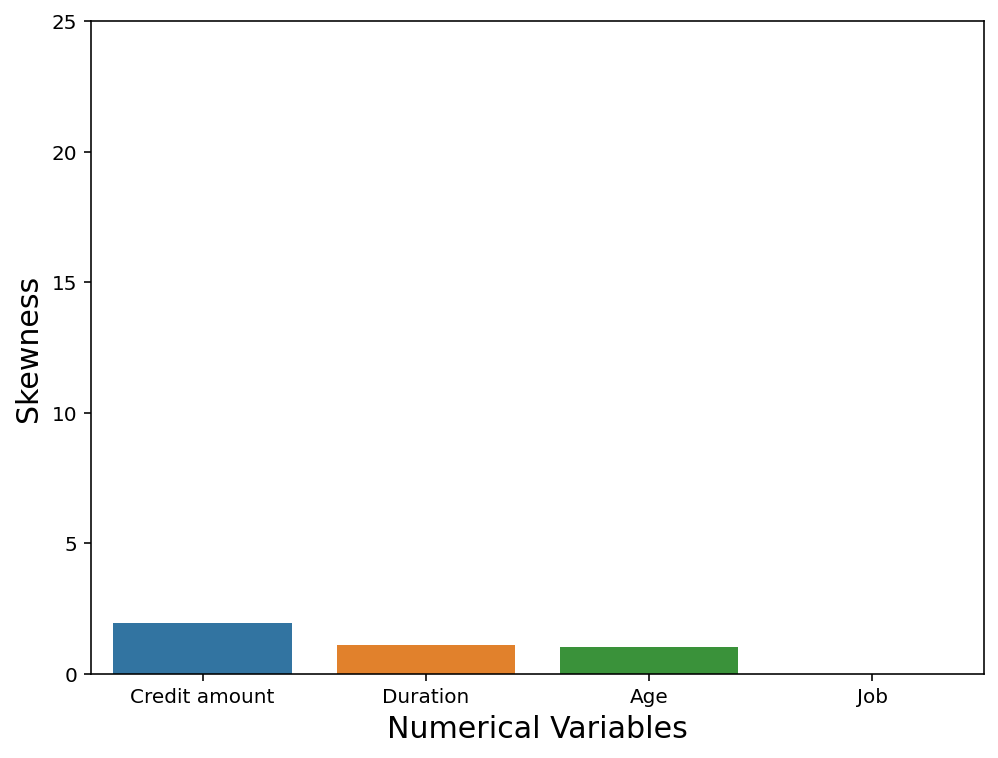

In [17]:
skewness = skewness.sort_values('Skewness', ascending=[0])

f, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [18]:

skewed_feats = skewed_feats[skewed_feats > 0.75]
# Apply log transformation on the features above the threshold 0.75
dt[skewed_feats.index] = np.log(dt[skewed_feats.index])
skewed_feats = dt[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats

Age              0.415629
Job             -0.373733
Credit amount    0.129092
Duration        -0.127223
dtype: float64

Above we can see that the degree of attribute distortion has been reduced

<h2>Transform categorical variables into numerical<h2>

In [19]:
cols = [] 
# determinar os atributos categoricos, caso o atributo tenha apenas duas classes
# mapea-lo para 0s e 1s 
for col in dt.columns:
  if dt[col].dtype == 'O':
    if dt[col].unique().shape[0]==2:
      dt[col] = dt[col].map({dt[col].unique()[0]: 0, dt[col].unique()[1]: 1})
    else:
      cols.append(col)
cols

['Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [20]:
dt['Saving accounts'].unique()

array(['little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [21]:
dt['Saving accounts'] = dt['Saving accounts'].map({'little': 0, 'moderate': 1, 'quite rich':2, 'rich':3})
cols.remove('Saving accounts')

In [22]:
dt = pd.get_dummies(dt, columns= cols, drop_first=True)
dt

,Age,Sex,Job,Saving accounts,Credit amount,Duration,Risk,Housing_own,Housing_rent,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,4.204693,0,2,0,7.063904,1.791759,0,1,0,0,0,0,0,0,0,1,0,0
1,3.091042,1,2,0,8.691315,3.871201,1,1,0,1,0,0,0,0,0,1,0,0
2,3.891820,0,1,0,7.647786,2.484907,0,1,0,0,0,0,0,1,0,0,0,0
3,3.806662,0,2,0,8.972337,3.737670,0,0,0,0,0,0,0,0,1,0,0,0
4,3.970292,0,2,0,8.490849,3.178054,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.433987,1,1,0,7.459339,2.484907,0,1,0,0,0,0,0,0,1,0,0,0
996,3.688879,0,3,0,8.257645,3.401197,0,1,0,0,0,1,0,0,0,0,0,0
997,3.637586,0,2,0,6.689599,2.484907,0,1,0,0,0,0,0,0,0,1,0,0
998,3.135494,0,2,0,7.520235,3.806662,1,0,0,0,0,0,0,0,0,1,0,0


<h2>Correlation Analysis<h2>

I perform some correlation analysis.

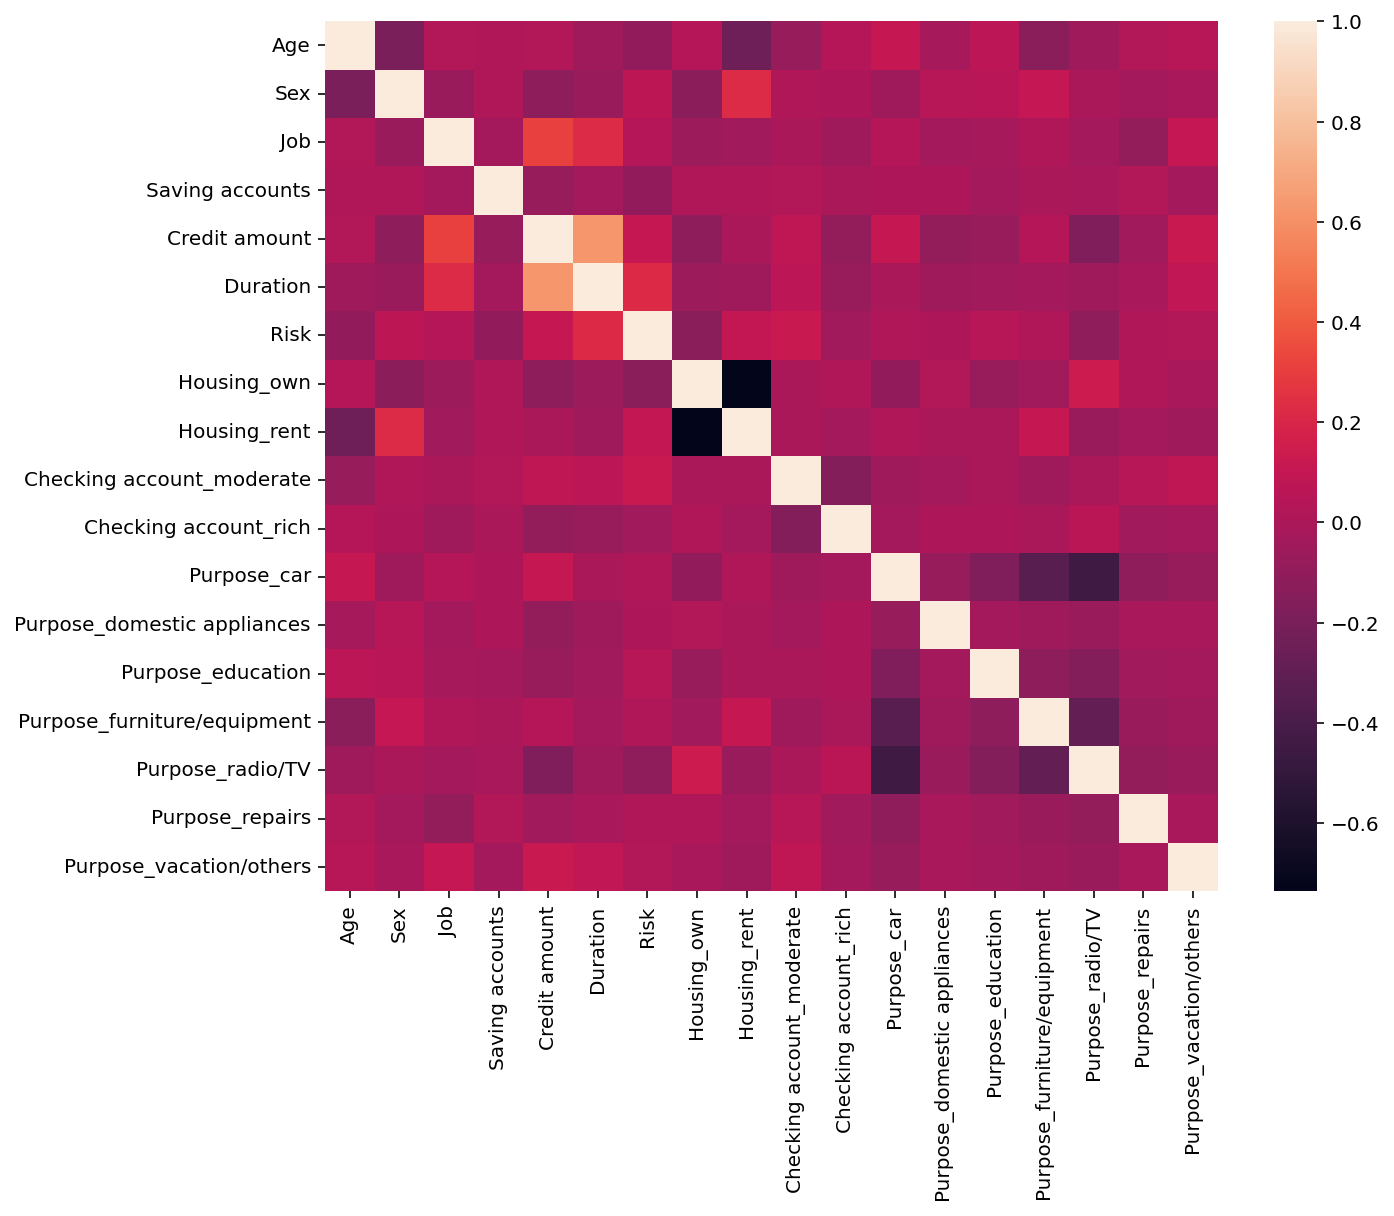

In [23]:
corrmat = dt.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrmat, vmax=1);

In [24]:
corr_degrees = corrmat['Risk'].sort_values(ascending=False)
corr_degrees = pd.DataFrame({'Correlation Degree' :corr_degrees})

# the following line returns the correlation degrees for features with a degree higher than 0.05 or less than -0.05
corr_degrees = corr_degrees[~corr_degrees['Correlation Degree'].between(-0.05,0.05)]
corr_degrees

,Correlation Degree
Risk,1.000000
Duration,0.214981
Checking account_moderate,0.119581
Credit amount,0.109570
Housing_rent,0.092785
Sex,0.075493
Age,-0.102740
Saving accounts,-0.102751
Purpose_radio/TV,-0.106922
Housing_own,-0.134589


The Duration attribute has the highest positive correlation with the Risk attribute, while the Housing_ own attribute has the lowest negative correlation with the Risk.

# Create train and test sets

In [25]:
# split the data into inputs and targets 

targets = dt['Risk']
targets

0      0
1      1
2      0
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: Risk, Length: 1000, dtype: int64

In [26]:
inputs=dt.drop(['Risk'],axis=1)
inputs

,Age,Sex,Job,Saving accounts,Credit amount,Duration,Housing_own,Housing_rent,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,4.204693,0,2,0,7.063904,1.791759,1,0,0,0,0,0,0,0,1,0,0
1,3.091042,1,2,0,8.691315,3.871201,1,0,1,0,0,0,0,0,1,0,0
2,3.891820,0,1,0,7.647786,2.484907,1,0,0,0,0,0,1,0,0,0,0
3,3.806662,0,2,0,8.972337,3.737670,0,0,0,0,0,0,0,1,0,0,0
4,3.970292,0,2,0,8.490849,3.178054,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.433987,1,1,0,7.459339,2.484907,1,0,0,0,0,0,0,1,0,0,0
996,3.688879,0,3,0,8.257645,3.401197,1,0,0,0,1,0,0,0,0,0,0
997,3.637586,0,2,0,6.689599,2.484907,1,0,0,0,0,0,0,0,1,0,0
998,3.135494,0,2,0,7.520235,3.806662,0,0,0,0,0,0,0,0,1,0,0


## Standardize the Data

I will select and standardize the attributes that are not binary so as not to add bias/noise. 

In [27]:
all_features = inputs.columns.values
features_to_ommit = []

for feature in all_features:
  if len(inputs[feature].unique()) == 2:
    features_to_ommit.append(feature)

inputs[features_to_ommit].head()

,Sex,Housing_own,Housing_rent,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,1,0,1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

features_to_scale = [feature for feature in inputs.columns.values if feature not in features_to_ommit ]
features_to_scale

['Age', 'Job', 'Saving accounts', 'Credit amount', 'Duration']

In [29]:
#create and fit scaler
scaler = StandardScaler()
scaler.fit(inputs[features_to_scale])

#scale selected data
inputs[features_to_scale] = scaler.transform(inputs[features_to_scale])

In [30]:
inputs

,Age,Sex,Job,Saving accounts,Credit amount,Duration,Housing_own,Housing_rent,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,2.271006,0,0.146949,-0.463409,-0.933901,-1.864869,1,0,0,0,0,0,0,0,1,0,0
1,-1.446152,1,0.146949,-0.463409,1.163046,1.708369,1,0,1,0,0,0,0,0,1,0,0
2,1.226696,0,-1.383771,-0.463409,-0.181559,-0.673790,1,0,0,0,0,0,1,0,0,0,0
3,0.942455,0,0.146949,-0.463409,1.525148,1.478913,0,0,0,0,0,0,0,1,0,0,0
4,1.488620,0,0.146949,-0.463409,0.904743,0.517289,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.301466,1,-1.383771,-0.463409,-0.424376,-0.673790,1,0,0,0,0,0,0,1,0,0,0
996,0.549317,0,1.677670,-0.463409,0.604255,0.900731,1,0,0,0,1,0,0,0,0,0,0
997,0.378110,0,0.146949,-0.463409,-1.416199,-0.673790,1,0,0,0,0,0,0,0,1,0,0
998,-1.297780,0,0.146949,-0.463409,-0.345911,1.597468,0,0,0,0,0,0,0,0,1,0,0


# Split the data into train and test data



In [31]:
# create test and train sets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(inputs,targets,test_size=0.2, random_state=365)

# Create models

In [35]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


### Random forest Model

In [40]:
random_seed = 1234
forest_model = RandomForestClassifier(max_depth=2, random_state=random_seed)
forest_model.fit(x_train, y_train,sample_weight=w_train)



RandomForestClassifier(max_depth=2, random_state=1234)

# Evaluate the Random Forest model

In [41]:
# obter as probabilidades
y_predict = forest_model.predict_proba(x_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
forest_model_roc_auc = roc_auc_score(y_test, y_predict)
print('Training score : {0:.3f}'.format(forest_model.score(x_train,y_train)))
print('ROC-AUC score : {0:.3f}'.format(forest_model_roc_auc))

Training score : 0.666
ROC-AUC score : 0.730


The model had a good performace in the test

### Decision tree Model


In [42]:
random_seed = 1234
tree_model = DecisionTreeClassifier(max_depth=2, random_state=random_seed)
tree_model.fit(x_train, y_train,sample_weight=w_train)



DecisionTreeClassifier(max_depth=2, random_state=1234)

# Evaluate the Decision tree model

In [43]:
# obtain the probabilites
y_predict = tree_model.predict_proba(x_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
tree_model_roc_auc = roc_auc_score(y_test, y_predict)
print('Training score : {0:.3f}'.format(tree_model.score(x_train,y_train)))
print('ROC-AUC score : {0:.3f}'.format(tree_model_roc_auc))

Training score : 0.579
ROC-AUC score : 0.654


To conclude:

Compared to the Random forest model, the decision tree model had a low performance. But both seem to perform much better in test than in training when the ROC-AUC' metric is used.

The best trained model is the random forest


----